In [64]:
import os
import cv2
import math
import numpy as np
from collections import OrderedDict
import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [65]:
np.random.seed(42)

In [66]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"
# INPUT_PATH = "../input/fer2013/train/"

total_images = 0
# Initialize a variable to keep track of the total number of images

for dir_ in os.listdir(INPUT_PATH):
    # Iterate over directories in the input path

    count = 0
    # # Initialize a variable to count the number of images in each directory
    
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    total_images += count
    # # Add the count of images in the current directory to the total count
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images: {total_images}")

surprise has 249 number of images
fear has 75 number of images
sadness has 84 number of images
happy has 207 number of images
anger has 135 number of images

total images: 750


`sadness` and `fear` has very low number of images as compared to other classes

In [67]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [68]:
img_arr = np.empty(shape=(total_images, 48, 48, 1))
# This line initializes an empty NumPy array img_arr with a shape of (total_images, 48, 48, 1). 
# It will be used to store image data.

img_label = np.empty(shape=(total_images))
# This line initializes an empty NumPy array img_label with a shape of (total_images). It will be used to 
# store corresponding labels for the images.

label_to_text = {}
# It will be used to map labels to their corresponding text representations.

idx = 0
label = 0
# They will be used as counters for indexing the image array and assigning labels, respectively.
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in  TOP_EMOTIONS:
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[idx] = np.expand_dims(cv2.imread(INPUT_PATH + dir_ + "/" + f, 0), axis=2)
            # This line reads an image file using OpenCV's cv2.imread() function, converts it to grayscale 
            # (0 as the second argument), and then expands its dimensions using np.expand_dims(). The resulting 
            # image is assigned to the img_arr array at index idx. The axis=2 argument specifies that the expansion 
            # is done along the third axis, adding an extra dimension of size 1.
            
            img_label[idx] = label
            idx += 1
            # This line increments the idx counter by 1 to move to the next index in the arrays.
        label_to_text[label] = dir_
        # This line adds an entry to the label_to_text dictionary, mapping the current label to the corresponding dir_value (emotion).
        label += 1

img_label = np_utils.to_categorical(img_label)
# This line converts the img_label array to categorical format using np_utils.to_categorical()

img_arr.shape, img_label.shape, label_to_text
# This line returns a tuple containing the shapes of img_arr, img_label, and the label_to_text dictionary, providing information 
# about the sizes of the arrays and the mapping of labels to text representations.

((750, 48, 48, 1),
 (750, 5),
 {0: 'surprise', 1: 'fear', 2: 'sadness', 3: 'happy', 4: 'anger'})

In [69]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, train_size=0.7, stratify=img_label, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((525, 48, 48, 1), (225, 48, 48, 1))

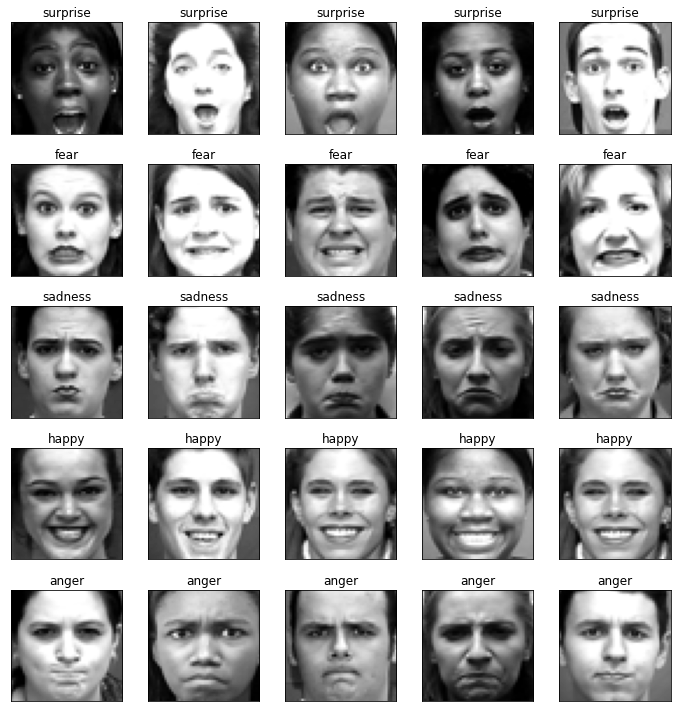

In [70]:
fig = pyplot.figure(1, (10,10))
# Create a figure with a size of 10x10 inches


idx = 0
for k in label_to_text:
    
    # # Randomly select 5 sample indices where the label is present
    sample_indices = np.random.choice(np.where(y_train[:,k]==1)[0], size=5, replace=False)
    sample_images = X_train[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(5,5,idx)   # Create a subplot at the current index
        ax.imshow(img.reshape(48,48), cmap='gray')  # # Display the image
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [71]:
# Data normalization to have Pixel values between 0 and 1
X_train = X_train / 255.
X_test = X_test / 255.

In [72]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input") # This is an input layer
    
    # We have 6 convolutional layers each fololowed with a normalization layer
    conv2d_1 = Conv2D(
        filters=64,   # 64 different features will be learnt by the layer
        kernel_size=(3,3),  # size of the convolutional filter
        activation='elu',   # will handle negative values efficiently
        padding='same',     # so that output feature maps have the same spatial dimensions as the input
        
        kernel_initializer='he_normal',  
        # initializes the weights using a Gaussian distribution with 
        # zero mean and a standard deviation scaled according to the number of input units
        
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    # Max Pooling Layers will downsample the spatial dimensions of the feature maps
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    
    # Downsampling will mitigate overfitting by randomly setting a fraction of inputs to 0 during training
    dropout_1 = Dropout(0.3, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.3, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,  # Increasing learning capacity and feature extraction
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    
    # Each neuron has a 30% chance of dropping out
    dropout_3 = Dropout(0.3, name='dropout_3')(maxpool2d_3)

    # Flatten converts the 2D feature maps into a 1D vector
    flatten = Flatten(name='flatten')(dropout_3)
    
    # A fully connected layer (Dense) is added with an activation function and kernel initializer
    dense_1 = Dense(
        128,   # 128 input neurons
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax', # allowing the network to make confident class predictions
        # This ensures that the output values fall within the range of [0, 1] and can be interpreted as class probabilities
        name='out_layer'
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

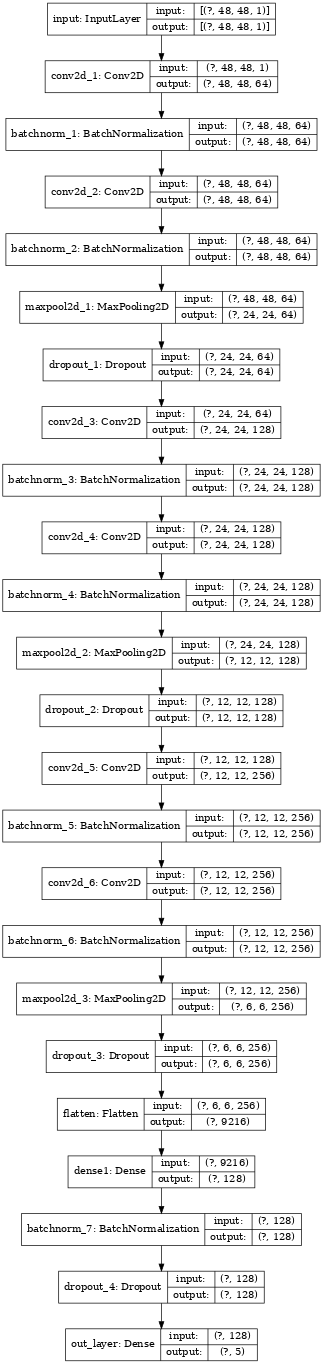

In [73]:
INPUT_SHAPE = (48, 48, 1)  # Height, width and number of channels (1 for grayscale)
optim = optimizers.Adam(0.001)
# Learning rate, it determines the step size at which the optimizer updates the weights based on the gradients

model = build_dcnn(input_shape=(48,48,1), num_classes=len(label_to_text))
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model.png')

In [74]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss for early stopping
    min_delta=0.00008,      # Minimum change in the monitored quantity to qualify as an improvement
    patience=12,            # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Verbosity mode (1: print messages)
    restore_best_weights=True   # Whether to restore weights from the epoch with the best monitored quantity
)

# Define ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',     # Monitor the validation accuracy for adjusting learning rate
    min_delta=0.0001,           # Minimum change in the monitored quantity to trigger learning rate adjustment
    factor=0.4,                 # Factor by which the learning rate will be reduced (new_lr = factor * old_lr)
    patience=6,                 # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                # Lower bound on the learning rate
    verbose=1                   # Verbosity mode (1: print messages)
)

# Create a list of callbacks to be used during training
callbacks = [
    early_stopping,
    lr_scheduler,
]

# Define batch size and number of epochs
batch_size = 10
epochs = 10

In [75]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [76]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),   # Training data generator with data augmentation
    validation_data=(X_test, y_test),   # Validation data
    steps_per_epoch=len(X_train) / batch_size,   # Number of steps (batches) per training epoch
    epochs=epochs,   # Number of training epochs
    callbacks=callbacks,   # List of callbacks to be used during training
    use_multiprocessing=True   # Whether to use multiprocessing for data generator (if available)
)


Train for 52.5 steps, validate on 225 samples
Epoch 1/10
53/52 [==============================] - 20s 371ms/step - loss: 2.0124 - accuracy: 0.3695 - val_loss: 13.2209 - val_accuracy: 0.2756
Epoch 2/10
53/52 [==============================] - 18s 337ms/step - loss: 1.3599 - accuracy: 0.5086 - val_loss: 1.8692 - val_accuracy: 0.5600
Epoch 3/10
53/52 [==============================] - 18s 342ms/step - loss: 0.9502 - accuracy: 0.6438 - val_loss: 1.0607 - val_accuracy: 0.6444
Epoch 4/10
53/52 [==============================] - 18s 334ms/step - loss: 0.9052 - accuracy: 0.6476 - val_loss: 0.8820 - val_accuracy: 0.6356
Epoch 5/10
53/52 [==============================] - 18s 345ms/step - loss: 0.8307 - accuracy: 0.6857 - val_loss: 0.7491 - val_accuracy: 0.7511
Epoch 6/10
53/52 [==============================] - 18s 337ms/step - loss: 0.7578 - accuracy: 0.7257 - val_loss: 0.5855 - val_accuracy: 0.6933
Epoch 7/10
53/52 [==============================] - 18s 343ms/step - loss: 0.7939 - accuracy: 0

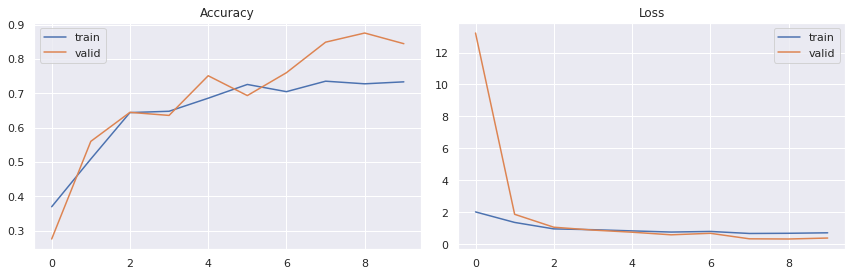

In [77]:
sns.set()   # Set the default style for seaborn plots
fig = pyplot.figure(0, (12, 4))   # Create a figure with a specific size

ax = pyplot.subplot(1, 2, 1)   # Create a subplot in a grid of 1 row and 2 columns, and select the first subplot
sns.lineplot(history.epoch, history.history['accuracy'], label='train')   # Plot the training accuracy
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')   # Plot the validation accuracy
pyplot.title('Accuracy')   # Set the title of the subplot
pyplot.tight_layout()   # Adjust the spacing between subplots and labels

ax = pyplot.subplot(1, 2, 2)   # Select the second subplot
sns.lineplot(history.epoch, history.history['loss'], label='train')   # Plot the training loss
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')   # Plot the validation loss
pyplot.title('Loss')   # Set the title of the subplot
pyplot.tight_layout()   # Adjust the spacing between subplots and labels

pyplot.savefig('epoch_history.png')   # Save the figure as an image file
pyplot.show()   # Display the figure


In [78]:
label_to_text

{0: 'surprise', 1: 'fear', 2: 'sadness', 3: 'happy', 4: 'anger'}

In [79]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'surprise': 0, 'fear': 1, 'sadness': 2, 'happy': 3, 'anger': 4}

test accuracy: 75.2344 %


              precision    recall  f1-score   support

           0       0.99      0.95      0.97        75
           1       0.76      0.59      0.67        22
           2       1.00      0.16      0.28        25
           3       0.84      1.00      0.91        62
           4       0.69      0.98      0.81        41

    accuracy                           0.84       225
   macro avg       0.86      0.73      0.73       225
weighted avg       0.87      0.84      0.82       225



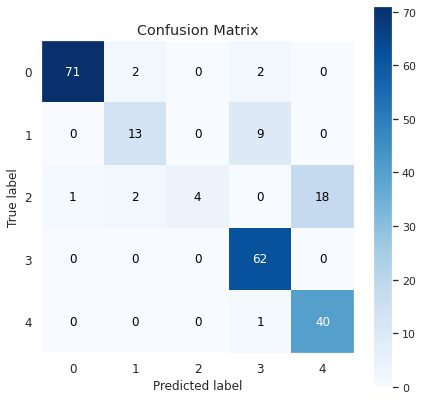

In [80]:
yhat_test = model.predict(X_test)
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_model3pipes.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu-9.21, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [81]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

[('conv2d_1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7cf3584dbb38>),
 ('conv2d_2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7cf3214b5c88>),
 ('conv2d_3',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7cf3213be630>),
 ('conv2d_4',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7cf3213f4c50>),
 ('conv2d_5',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7cf32139c5f8>),
 ('conv2d_6',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7cf3206d7978>)]

#### Plot Filters

In [82]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_4"]

CPU times: user 5.2 s, sys: 355 ms, total: 5.56 s
Wall time: 5.02 s


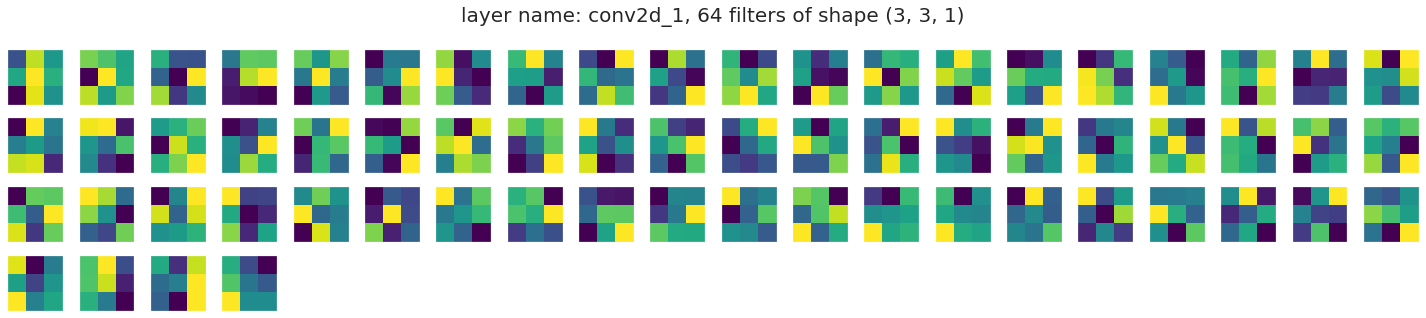

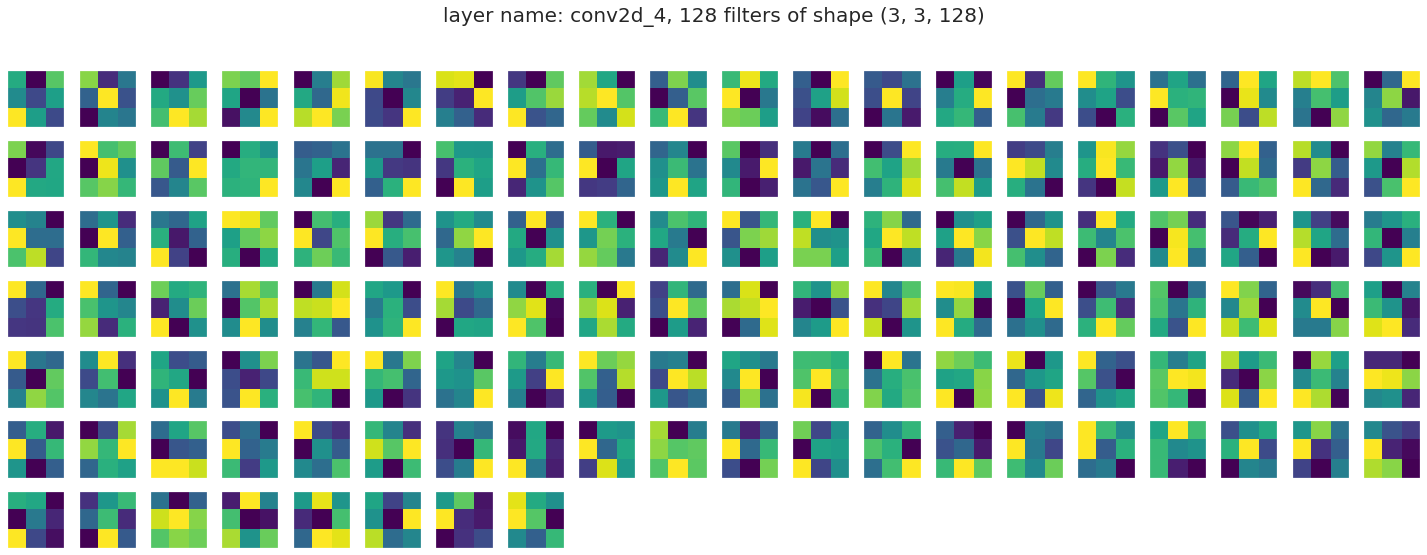

In [83]:
%%time

idx = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:        
        layer_output = layer[1].output
        filters, bias = layer[1].get_weights()     
        filters = (filters - filters.min()) / (filters.max() - filters.min())

        n_filters = filters.shape[-1]
        cols = 20
        rows = n_filters // cols + int(n_filters % cols > 0)
        fig = pyplot.figure(idx, (20, rows))

        for i, f in enumerate(np.rollaxis(filters, 3)):
            ax = pyplot.subplot(rows, cols, i+1)
            f = np.mean(f, axis=2)
            ax.imshow(f, cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, {filters.shape[3]} filters of shape {filters.shape[:-1]}", fontsize=20, y=1.1)
        pyplot.tight_layout()
        idx += 1


#### Plot Feature Maps

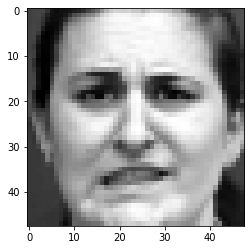

In [84]:
sns.reset_orig()
sample_img = X_test[0] # select a random image
pyplot.imshow(sample_img.reshape(48,48), cmap="gray")
pyplot.show()

In [85]:
sample_img = np.expand_dims(sample_img, axis=0)
sample_img.shape

(1, 48, 48, 1)

In [86]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_4"]

CPU times: user 57.1 s, sys: 1.91 s, total: 59 s
Wall time: 57.3 s


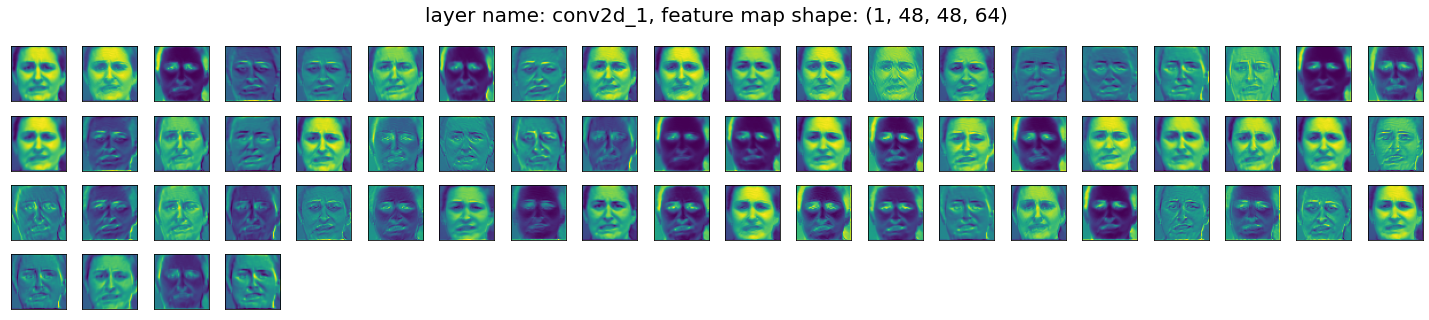

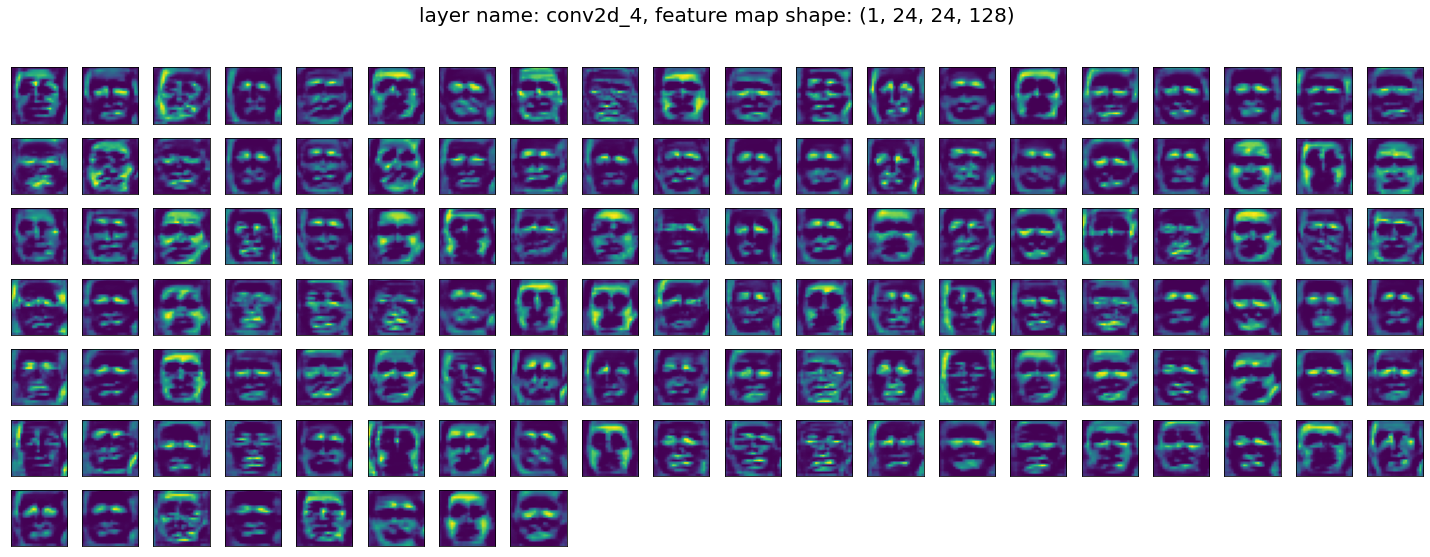

In [87]:
%%time

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(sample_img)

        cols = 20
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
        fig = pyplot.figure(i, (20, rows))        
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            pyplot.tight_layout()

We can see that the first convolutional layer has detected many edges in the image and indeed this is what we expected.

#### Plot Class Activation Map (CAM) 
The following CAM is taken from [here](https://github.com/himanshurawlani/convnet-interpretability-keras/blob/master/Visualizing%20heatmaps/heatmap_visualization_using_gradcam.ipynb).

In [88]:
INTERESTED_CONV_LAYERS = ["conv2d_1", "conv2d_2", "conv2d_3", "conv2d_4", "conv2d_5", "conv2d_6"]

In [89]:
preds = model.predict(sample_img)
label_to_text[np.argmax(preds[0])]

'happy'

In [90]:
pred_vector_output = model.output[:, np.argmax(preds[0])]
pred_vector_output

<tf.Tensor 'strided_slice_7:0' shape=(None,) dtype=float32>

In [91]:
heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([sample_img])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

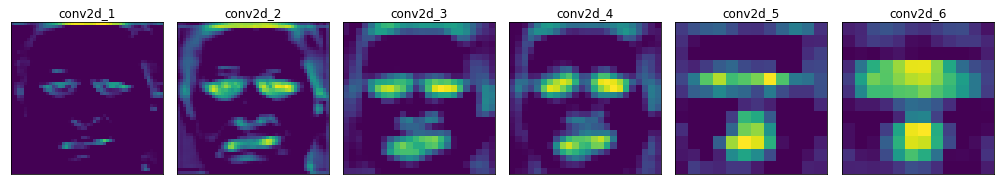

In [92]:
fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

We can see that our model focuses on important aspects of the image i.e., `lips`, `eyes` and `eyebrows`.

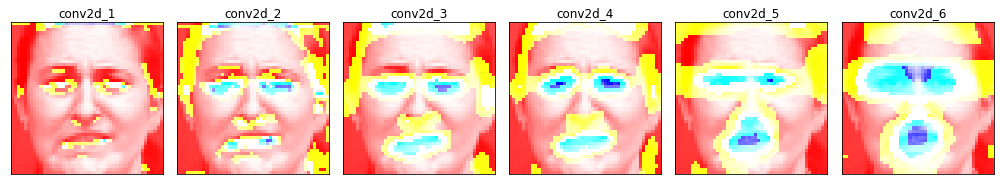

In [93]:
fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    
    img_hm = cv2.resize(img_heatmap, (48,48))
    img_hm = np.uint8(255 * img_hm)

    img_hm = cv2.applyColorMap(img_hm, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = img_hm * 0.4 + sample_img

    ax = pyplot.subplot(1, 6, i+1)
    ax.imshow(superimposed_img[0,:,:])
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()